# Исследование эффективности операторов колл-центров

Для провайдера виртуальный телефонии «Нупозвони» исследуется эффективность операторов колл-центров. 

Клиенты сервиса «Нупозвони»: колл-центры, которые: 

- распределяют входящие вызовы на операторов,
- совершают исходящие вызовы силами операторов.
- также операторы могут делать внутренние вызовы —  вызовы друг между другом внутри сети виртуальной телефонии.

**Заказчик исследования**: отдел продуктовой разработки «Нупозвони». В дальнейшем на основе исследования будет принято решение о целесообразности разработки новой услуги сервиса: оценка эффективности операторов.

**Задачи исследования**:
- провести исследовательский анализ данных и сформулировать возможные критерии неэффективности операторов
- определить неэффективных операторов
- определить клиентов с неэффективными операторами

**Ход исследования**:
Исследование пройдёт в 4 этапа:
 1. Обзор данных.
 2. Предобработка данных (удаление пропусков, обработка дубликатов, обработка аномальных значений).
 3. Исследовательский анализ данных.
 4. Проверка гипотез

# Материалы:
* [Презентация](https://docs.google.com/presentation/d/1yyiCLMRF8_kQLulYwbK13KbdH9PBc6dfc_t2RHfypjU/edit#slide=id.g21c1f1332c4_0_164)
* [Дашборд](https://public.tableau.com/app/profile/ekaterina6973/viz/Graduation_project_Tkachenko/Dashboard1?publish=yes)

## Общая информация

In [1]:
#импорт библиотек 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from scipy import stats as st
import math as mth

In [2]:
#чтение файла
try:
    clients = pd.read_csv('/datasets/telecom_clients.csv')
except:
    clients = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_clients.csv')

In [3]:
clients.sample(10)#рандомные 10 строк

,user_id,tariff_plan,date_start
183,167998,C,2019-10-09
722,166797,B,2019-08-20
726,166702,B,2019-08-15
282,167533,C,2019-09-19
169,166418,C,2019-08-02
617,166970,B,2019-08-27
30,168112,A,2019-10-14
696,168245,B,2019-10-17
419,167407,C,2019-09-16
582,167738,B,2019-09-27


**Описание данных**
- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `tariff_plan` — Текущий тарифный план клиента
- `date_start` — Дата регистрации клиента в сервисе

In [4]:
#чтение файла
try:
    data = pd.read_csv('/datasets/telecom_dataset.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_dataset.csv')

In [5]:
data.sample(10)#рандомные 10 строк

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
46154,168091,2019-11-18 00:00:00+03:00,in,False,958432.0,False,1,128,137
31142,167402,2019-10-21 00:00:00+03:00,in,False,NaN,True,1,0,26
28038,167176,2019-11-11 00:00:00+03:00,out,False,905104.0,True,2,0,96
38412,167650,2019-11-16 00:00:00+03:00,out,False,921318.0,True,35,0,578
6341,166541,2019-10-24 00:00:00+03:00,out,False,908960.0,False,1,90,98
9556,166658,2019-11-07 00:00:00+03:00,out,False,890412.0,False,14,1082,1213
21269,167031,2019-09-23 00:00:00+03:00,out,False,910520.0,False,1,169,176
21774,167035,2019-11-25 00:00:00+03:00,in,False,923526.0,False,23,2560,2761
28366,167180,2019-10-18 00:00:00+03:00,out,False,905930.0,False,4,1319,1384
29509,167246,2019-09-10 00:00:00+03:00,in,False,908078.0,False,1,45,79


**Описание данных**
- `user_id` — Идентификатор клиентского аккаунта колл-центра в сервисе
- `date` — Дата статистики
- `direction` — Направление вызовов (out - исходящий вызов, in — входящий вызов)
- `internal` — Является ли звонок внутренним звонком между операторами клиента
- `operator_id` — Идентификатор оператора
- `is_missed_call` — Является ли звонок пропущенным
- `calls_count` — Количество звонков
- `call_duration` — Длительность звонка (без учета времени ожидания)
- `total_call_duration` — Длительность звонка (с учетом времени ожидания)

In [6]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


**Вывод:**

Названия столбцов корректны в обоих датафреймах. 


В таблице с данными о клиентах пропусков нет. Пропуски встречаются в данных о звонках в следующих столбцах:
- `internal`
- `operator_id`
    
    
Тип данных требуется поменять у следующих столбцов:
- `date_start` - таблица **clients**.  Должен быть тип данных `date`
- `date` - таблица **data**. Должен быть тип данных `date`
- `operator_id` - таблица **data**.  Должен быть тип данных `int`

## Предобработка данных

### Изменение типа данных

In [8]:
clients['date_start'] = pd.to_datetime(clients['date_start'])# изменение типа

In [9]:
data['date'] = pd.to_datetime(data['date'])# изменение типа

In [10]:
data['date'] = pd.to_datetime(data['date'])# изменение типа

In [11]:
data = data.astype({"operator_id": "Int64"})# изменение типа

### Удаление пропусков

Посмотрим процент пропусков. Затем примем решение о необходимости удалить строки или нет. Информации или логических закономерностей для заполнения пропусков нет.

In [12]:
pd.DataFrame(round(data.isna().mean()*100,1))

,0
user_id,0.0
date,0.0
direction,0.0
internal,0.2
operator_id,15.2
is_missed_call,0.0
calls_count,0.0
call_duration,0.0
total_call_duration,0.0


Пропуски в столбце `internal` можно удалить ввиду небольшого процента. 

In [13]:
good_data = data.dropna(subset=['internal'])# удаление пропусков

Ввиду большого количества пропусков в столбце `operator_id`, посмотрим типы звонков среди строк с пропущенными значениями

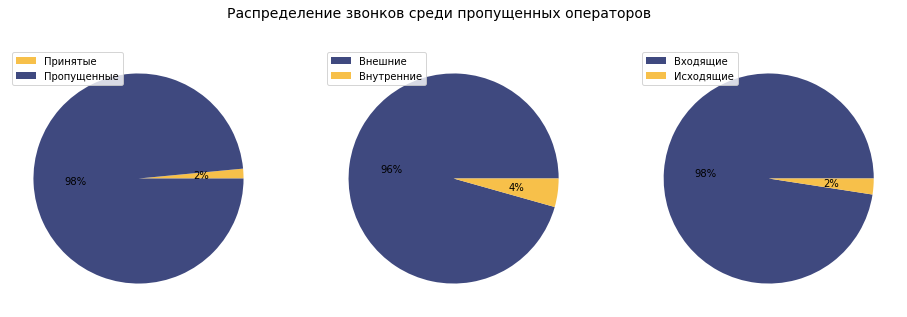

In [14]:
plt.figure(figsize=(16,5))
plt.suptitle('Распределение звонков среди пропущенных операторов', size=14)

ax1 = plt.subplot(1, 3, 1)
good_data.query('operator_id.isna()').groupby('is_missed_call')['calls_count'].count().\
plot.pie(labels=None,autopct='%1.f%%', ylabel='',colors=['#F7C04A','#3F497F'],ax=ax1)
plt.legend(loc="upper left",labels=['Принятые', 'Пропущенные'])

ax2 = plt.subplot(1, 3, 2)
good_data.query('operator_id.isna()').groupby('internal')['calls_count'].count().\
plot.pie(labels=None,autopct='%1.f%%', ylabel='',colors=['#3F497F','#F7C04A'],ax=ax2)
plt.legend(loc="upper left",labels=['Внешние', 'Внутренние'])

ax3 = plt.subplot(1, 3, 3)
good_data.query('operator_id.isna()').groupby('direction')['calls_count'].count().\
plot.pie(labels=None,autopct='%1.f%%',ylabel='',colors=['#3F497F','#F7C04A'],ax=ax3)
labels=['Входящие', 'Исходящие']
plt.legend(loc="upper left",labels=['Входящие', 'Исходящие'])
plt.show()

Большинство звонков - это пропущенные внешние входящие звонки. Так как превалирует определенная группа звонков (а не небольшое кол-во строк в каждой группе), их удаление повлияет на результат. Заменим значения `operator_id` для пропущенных внешних входящих звонков нулем. Остальные строки удалим

In [15]:
# заполнение пропусков
good_data.loc[(good_data['is_missed_call']==True) & (good_data['operator_id'].isna())\
              & (good_data['internal']==False) & (good_data['direction'] =="in"), 'operator_id'] = 0

In [16]:
# проверка кол-ва строк после заполнения
good_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53785 non-null  int64                                
 1   date                 53785 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53785 non-null  object                               
 3   internal             53785 non-null  object                               
 4   operator_id          53206 non-null  Int64                                
 5   is_missed_call       53785 non-null  bool                                 
 6   calls_count          53785 non-null  int64                                
 7   call_duration        53785 non-null  int64                                
 8   total_call_duration  53785 non-null  int64                                
dtypes: Int6

In [17]:
good_data = good_data.dropna(subset=['operator_id'])# удаление пропусков

### Обработка дубликатов

In [18]:
clients.duplicated().sum()# наличие дубликатов 

0

In [19]:
data.duplicated().sum()# наличие дубликатов 

4900

In [20]:
data[data.duplicated()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-05 00:00:00+03:00,out,False,880020,True,8,0,50
28,166377,2019-08-12 00:00:00+03:00,in,False,<NA>,True,2,0,34
44,166377,2019-08-14 00:00:00+03:00,out,False,880026,False,10,1567,1654
45,166377,2019-08-14 00:00:00+03:00,in,False,<NA>,True,1,0,3
51,166377,2019-08-15 00:00:00+03:00,out,False,880026,False,11,1413,1473
...,...,...,...,...,...,...,...,...,...
53869,168601,2019-11-25 00:00:00+03:00,in,False,952914,False,7,1229,1282
53874,168601,2019-11-26 00:00:00+03:00,in,False,952914,False,4,539,562
53875,168601,2019-11-26 00:00:00+03:00,in,False,<NA>,True,3,0,35
53885,168603,2019-11-20 00:00:00+03:00,out,False,959118,True,3,0,89


4900 строк являются точными копиями других строк в DataFrame. Причиной могла послужить ошибка при выгрузке данных. 
Удалим данные строки

In [21]:
good_data = good_data.drop_duplicates()# удалим дубликаты

### Добавление столбцов

In [22]:
good_data['day_of_week'] = good_data['date']. dt.day_name ()# день недели

In [23]:
# среднее время 1 звонка без времени ожидания
good_data['one_call_duration'] = good_data['call_duration']/good_data['calls_count']

In [24]:
# среднее время 1 звонка с временем ожидания
good_data['one_total_call_duration'] = good_data['total_call_duration']/good_data['calls_count']

In [25]:
# среднее время ожидания 1 звонка
good_data['waiting_time'] = good_data['one_total_call_duration'] - good_data['one_call_duration']

### Обработка аномалий

Проверим есть ли среди пропущенных звонков, иные значения в столбце `call_duration` (длительность звонка без учета времени ожидания) кроме 0.

In [26]:
# уникальные значения длительности звонка среди пропущенных звонков
good_data[good_data['is_missed_call']==True]['call_duration'].unique()

array([  0, 165,   1, 133,  31,  79,  38,  53,  47, 109,  27,  48,  64,
       107, 241,  20,  24,  21,   2,  25,  71,  81,  93,   3,  19,  39,
        58, 327,  35, 252,  28,  18,  61,  87,  75,  23,  62, 148,  17,
        44,  12,  34,   5,  15,  16, 112, 147, 113,  57,  78,   4,  43,
        74,  46,  94,  96, 135, 161,   8,   7,  59,   6,  51, 102,  49,
        84, 119, 100,  36, 120, 125, 131, 140,  88, 244,  52, 139,  60,
        30,  66, 234, 295, 332, 117,  72,  56,  14,  69,  11,  37, 162,
       101,  91, 153, 188, 150, 548, 670, 636, 518, 194, 231, 130, 132,
        90, 570, 638, 217, 223, 601, 103, 318,  99, 450, 233, 175, 142,
       263, 525, 532, 198, 443,  55, 221, 379, 269, 741, 317, 463, 382,
        50,  40])

Посчитаем количество таких строк.

In [27]:
good_data.query('(is_missed_call==True) and (call_duration!=0)')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,day_of_week,one_call_duration,one_total_call_duration,waiting_time
1606,166405,2019-11-19 00:00:00+03:00,in,False,939478,True,1,165,173,Tuesday,165.0,173.0,8.0
1635,166405,2019-11-21 00:00:00+03:00,in,False,882686,True,1,1,5,Thursday,1.0,5.0,4.0
1657,166405,2019-11-22 00:00:00+03:00,in,False,882686,True,1,1,5,Friday,1.0,5.0,4.0
2283,166407,2019-09-23 00:00:00+03:00,in,False,888534,True,1,133,156,Monday,133.0,156.0,23.0
2869,166482,2019-11-05 00:00:00+03:00,in,False,934074,True,1,1,15,Tuesday,1.0,15.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51599,168336,2019-11-01 00:00:00+03:00,in,False,947304,True,1,1,20,Friday,1.0,20.0,19.0
51664,168336,2019-11-12 00:00:00+03:00,in,False,947304,True,1,69,72,Tuesday,69.0,72.0,3.0
51693,168336,2019-11-15 00:00:00+03:00,in,False,947304,True,1,46,49,Friday,46.0,49.0,3.0
51853,168336,2019-11-27 00:00:00+03:00,in,False,958416,True,1,40,65,Wednesday,40.0,65.0,25.0


Так как таких строк не много (295) и они противоречат здравому смыслу, удалим их. Если звонок пропущен, его длительность (без учета времени ожидания) не может быть отличной от 0.

In [28]:
# удаление строк с логической ошибкой
good_data = good_data.query('(is_missed_call==True) and (call_duration==0) or (is_missed_call==False) ')

Определим в каких единицах измерения представлены данные. Для этого проверим среднее время 1 звонка.

count    48066.000000
mean        66.453332
std        124.267338
min          0.000000
25%          0.000000
50%         24.500000
75%         90.271853
max       3550.000000
Name: one_call_duration, dtype: float64

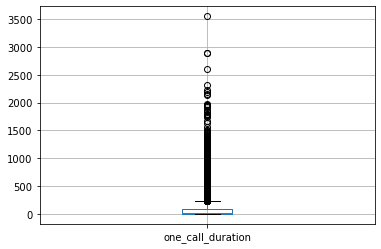

In [29]:
good_data.boxplot('one_call_duration')# обработка аномалий; построение диаграммы размаха до обработки
good_data['one_call_duration'].describe()

Среднее значение 1 звонка без учета времени ожидания 66.45. Исходя из этого, можно сделать вывод, что данные представлены в секундах. Так как среднее значение 1 звонка больше 1 часа нереалистично. И потребовало бы от нас удалить большинство данных ввиду нереалистичности. 

Проверим столбцы с числовыми значения на предмет аномалий. Строки с совсем нереалистичными значениями удалим.

count     48066.000000
mean        872.159864
std        3794.325344
min           0.000000
25%           0.000000
50%          40.000000
75%         584.000000
max      144395.000000
Name: call_duration, dtype: float64

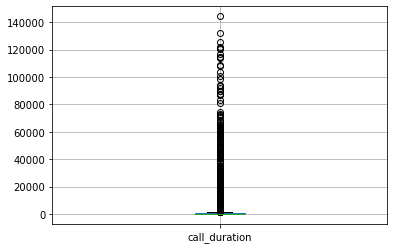

In [30]:
good_data.boxplot('call_duration')# обработка аномалий; построение диаграммы размаха до обработки
good_data['call_duration'].describe()

In [31]:
h = 24 #количество часок в сутках
m = 60 #количество минут в часе
s = 60 #количество секунд в минуте
max_call_duration = h*m*s #число секунд в сутках
max_call_duration

86400

`operator_id` это рабочий аккаунт, с которого может работать сразу несколько человек. Коллц-центры бывают круглосуточные, следовательно,  суммарная продолжительность звонков в сутки на один аккаунт `operator_id` не может превышать 86400сек. Сгруппируем данные по дням и operator_id. 

In [32]:
check_call_duration = good_data.pivot_table(index = ['operator_id','date'], values = 'call_duration', aggfunc='sum')\
.reset_index()
check_call_duration.columns = ['data','operator_id','sum_call_duration']
check_call_duration

,data,operator_id,sum_call_duration
0,0,2019-08-02 00:00:00+03:00,0
1,0,2019-08-03 00:00:00+03:00,0
2,0,2019-08-04 00:00:00+03:00,0
3,0,2019-08-05 00:00:00+03:00,0
4,0,2019-08-06 00:00:00+03:00,0
...,...,...,...
19750,972412,2019-11-28 00:00:00+03:00,1928
19751,972460,2019-11-27 00:00:00+03:00,129
19752,972460,2019-11-28 00:00:00+03:00,1089
19753,973120,2019-11-27 00:00:00+03:00,5


In [33]:
check_call_duration['sum_call_duration'].describe()

count     19755.000000
mean       2122.056998
std        5887.632985
min           0.000000
25%         138.000000
50%         688.000000
75%        2223.000000
max      145006.000000
Name: sum_call_duration, dtype: float64

Так как максимальное значение превышает 86400 сек, значит такие строки точно есть. 

Строки в изначальном датасете сгруппированы по 3-м параметрам: входящий/исходящий звонок (`direction`), внутренний/внешний (`internal`), пропущенный или нет (`is_missed_call`), следовательно, каждая строка может подразумевать период меньше суток+ необходимы перерывы на обед. Таким образом, удалим все строки, значения `call_duration` в которых < 86400сек. Также поступим и со столбцом `total_call_duration`. 

In [34]:
# удаление аномальных значений
good_data = good_data.query('(call_duration<=86400) or (call_duration.isna())')

count     48043.000000
mean       1108.762067
std        3571.885584
min           0.000000
25%          48.000000
50%         216.000000
75%         917.000000
max      100139.000000
Name: total_call_duration, dtype: float64

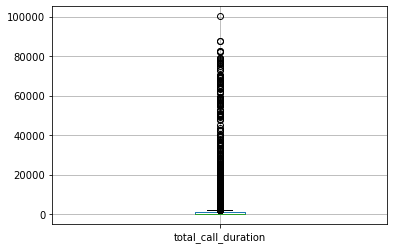

In [35]:
good_data.boxplot('total_call_duration')# обработка аномалий; построение диаграммы размаха до обработки
good_data['total_call_duration'].describe()

In [36]:
good_data = good_data.query('(total_call_duration<=86400) or (total_call_duration.isna())')# удаление аномальных значений

count    48040.000000
mean        16.259888
std         60.555609
min          1.000000
25%          1.000000
50%          4.000000
75%         13.000000
max       4817.000000
Name: calls_count, dtype: float64

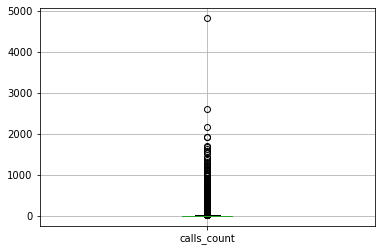

In [37]:
good_data.boxplot('calls_count')# обработка аномалий; построение диаграммы размаха до обработки
good_data['calls_count'].describe()

Если допустить, что каждый звонок длится всего 1 минуту, то в день можем быть не более чем 1440 звонков. Удалим строки, в которых `calls_count`  превышает 1500.

In [38]:
good_data = good_data.query('(calls_count<=1500) or (calls_count.isna())')# удаление аномальных значений

count    48029.000000
mean        16.871561
std         13.822074
min          0.000000
25%          8.000000
50%         14.600000
75%         22.289855
max        465.000000
Name: waiting_time, dtype: float64

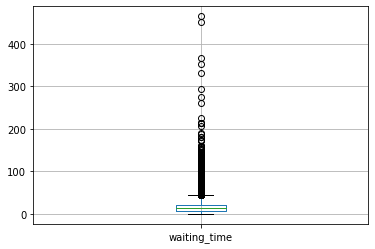

In [39]:
good_data.boxplot('waiting_time')# обработка аномалий; построение диаграммы размаха до обработки
good_data['waiting_time'].describe() 

Так как минимальное значение в столбце `waiting_time`=0, значит строк, где `call_duration` превышает `total_call_duration` - нет.

In [40]:
round(100*(data.shape[0]-good_data.shape[0])/data.shape[0],2)# итоговый процент удаленных строк

10.9

**Вывод:**

В основном датасете были удалены дубликаты, пропуски. Пропуски в колонке с `operator_id` для входящих, пропущенных и внешних были заменены на 0. Столбцы с датами были приведены к соответствующему типу. Также были удалены выбросы.
Общая доля удаленных строк не превысила 11%

## Анализ данных

In [41]:
good_data['date'].max()# последняя дата

Timestamp('2019-11-28 00:00:00+0300', tz='pytz.FixedOffset(180)')

In [42]:
good_data['date'].min()# первая дата

Timestamp('2019-08-02 00:00:00+0300', tz='pytz.FixedOffset(180)')

Данные представлены в диапазоне между 28 ноября 2019г. и 8 февраля 2019г.

In [43]:
# сводная по дням недели
call_per_day = good_data.pivot_table(index='day_of_week', values='calls_count',\
                                     aggfunc='sum').reset_index()
call_per_day = call_per_day.sort_values(by='calls_count', ascending=False)
call_per_day

,day_of_week,calls_count
4,Thursday,142118
5,Tuesday,139129
6,Wednesday,136960
1,Monday,125285
0,Friday,124110
2,Saturday,53223
3,Sunday,37193


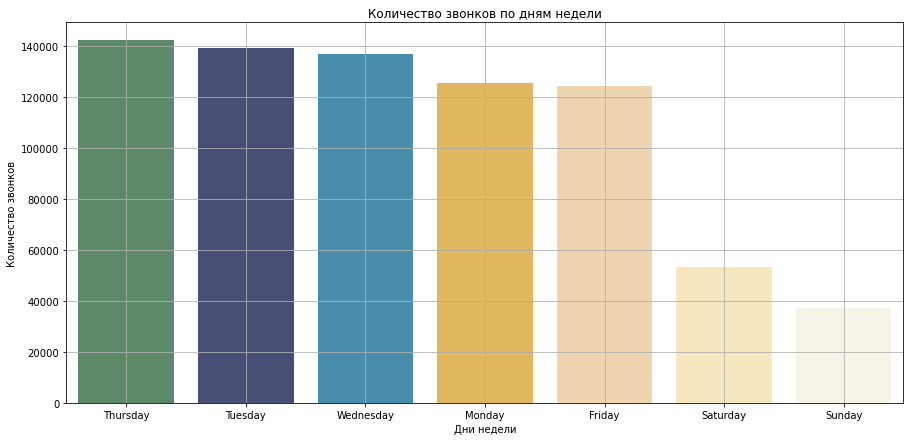

In [44]:
plt.figure(figsize=(15, 7))
colors=['#539165','#3F497F','#3795BD','#F7C04A','#FAD6A5','#FFEBB7','#F8F5E4']
sns.barplot(data=call_per_day, x='day_of_week',y='calls_count',palette=colors)
plt.title("Количество звонков по дням недели")
plt.ylabel("Количество звонков")
plt.xlabel("Дни недели")
plt.grid()


В выходные дни количество звонков меньше чем в будни.

### Категоризация колл-центров

Посмотрим соотношение входящих/исходящих звонков

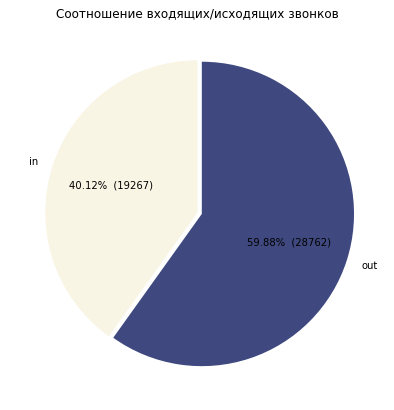

In [45]:
plt.figure(figsize=(7, 7))
explode = (0, 0.03)
valu1 = good_data.groupby('direction')['calls_count'].count().tolist()
def make_autopct(valu1):
    """ Эта функция позволяет показать на круговой диаграмме относительные и абсолютные значения
    
    Она принимает на вход список из абсолютных значений, по которым строится диаграмма
    """
    def my_autopct(pct):
        total = sum(valu1)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
good_data.groupby('direction')['calls_count'].count().\
plot(kind='pie',autopct=make_autopct(valu1),ylabel='',colors=['#F8F5E4','#3F497F'], explode=explode,\
     startangle=90, title='Cоотношение входящих/исходящих звонков');

60% звонков исходящие. Посчитаем долю входящих/исходящих звонков для каждого колл-центра. 

In [46]:
# доля входящих/исходящих звонков для каждого колл-центра
user_per_direction = good_data.pivot_table(index='user_id', columns = 'direction',\
                values='calls_count', aggfunc='sum', margins=True, margins_name='total').reset_index()

user_per_direction['ratio_in'] = round(100*user_per_direction['in']/user_per_direction['total'],2)
user_per_direction['ratio_out'] = 100-user_per_direction['ratio_in']
user_per_direction

direction,user_id,in,out,total,ratio_in,ratio_out
0,166377,196.0,4952.0,5148,3.81,96.19
1,166391,17.0,1.0,18,94.44,5.56
2,166392,208.0,NaN,208,100.00,0.00
3,166399,22.0,NaN,22,100.00,0.00
4,166405,7706.0,9825.0,17531,43.96,56.04
...,...,...,...,...,...,...
302,168598,101.0,NaN,101,100.00,0.00
303,168601,105.0,587.0,692,15.17,84.83
304,168603,1.0,14.0,15,6.67,93.33
305,168606,11.0,16.0,27,40.74,59.26


Колл-центры, у которых больше 50% входящих звонков, примем за специализирующихся на входящих звонках, остальные на исходящих.

In [47]:
def in_out(ratio_in):
    """ Функция определяет категорию в зависимости от доли звонков
    """
    if ratio_in>50:
        return 'in_group'
    return 'out_group'
user_per_direction['group'] = user_per_direction['ratio_in'].apply(in_out)# применение функции к столбцу
user_per_direction = user_per_direction[['user_id','group']]# оставили только релевантные столбцы

In [48]:
# присоединие столбца с категорией к основной таблице
good_data = good_data.merge(user_per_direction, on='user_id',how='left')

In [49]:
good_data.info()# проверка количества строк после присоединения

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48029 entries, 0 to 48028
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype                                
---  ------                   --------------  -----                                
 0   user_id                  48029 non-null  object                               
 1   date                     48029 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction                48029 non-null  object                               
 3   internal                 48029 non-null  object                               
 4   operator_id              48029 non-null  Int64                                
 5   is_missed_call           48029 non-null  bool                                 
 6   calls_count              48029 non-null  int64                                
 7   call_duration            48029 non-null  int64                                
 8   total_call_duration      48029 non-null  int64

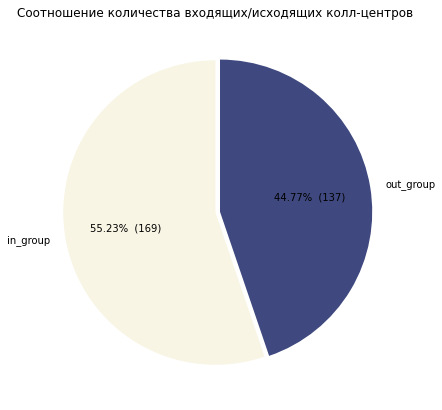

In [50]:
# соотношение входящих/исходящих колл-центров
plt.figure(figsize=(7, 7))
explode = (0, 0.03)
valu1 = good_data.groupby('group')['user_id'].nunique().tolist()
def make_autopct(valu1):
    """ Эта функция позволяет показать на круговой диаграмме относительные и абсолютные значения
    
    Она принимает на вход список из абсолютных значений, по которым строится диаграмма
    """
    def my_autopct(pct):
        total = sum(valu1)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
good_data.groupby('group')['user_id'].nunique().\
plot(kind='pie',autopct=make_autopct(valu1),ylabel='',colors=['#F8F5E4','#3F497F'], explode=explode,\
     startangle=90, title='Cоотношение количества входящих/исходящих колл-центров');

55% колл-центров относится к категории входящие.

### Анализ данных по входящим звонкам

In [51]:
# срез  колл-центров, специализирующихся на входящих звонках
good_data_in = good_data.query('group=="in_group"')

Определим:
- количество колл-центров, специализирующихся на входящих звонках 
- общее количество операторов,  работающих в таких колл-центрах
- количество операторов, для каждого колл-центра

In [52]:
#количество колл-центров, специализирующихся на входящих звонках 
good_data_in['user_id'].nunique()

169

In [53]:
#суммарное количество операторов, работающих в колл-центрах, специализирующихся на входящих звонках
good_data_in['operator_id'].nunique()

339

In [54]:
#количество операторов, для каждого колл-центра
quantity_per_user = good_data_in.pivot_table(index='user_id', values='operator_id', aggfunc='nunique')

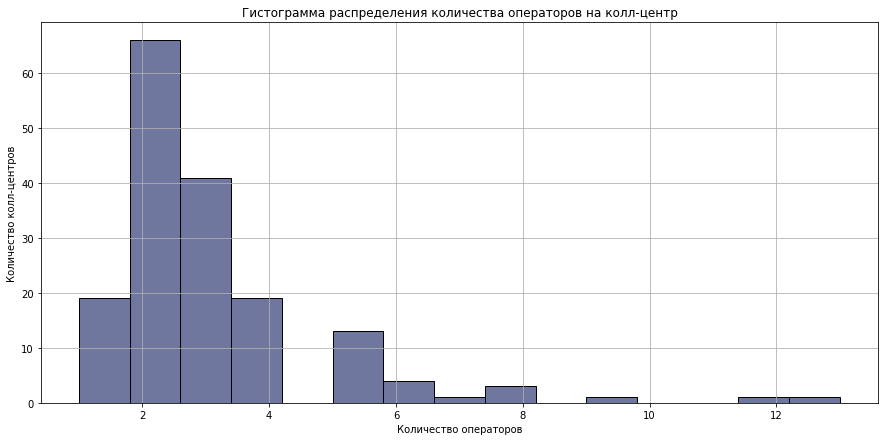

In [55]:
plt.figure(figsize=(15, 7))
sns.histplot(data=quantity_per_user, x="operator_id", bins=15, color='#3F497F')
plt.title("Гистограмма распределения количества операторов на колл-центр")
plt.ylabel("Количество колл-центров")
plt.xlabel("Количество операторов")
plt.grid()

В большинстве колл-центров работают по 2 оператора

#### Оценка эффективности по среднему времени ожидания

Построим гистограмму распределения длительности входящих звонков и времени ожидания

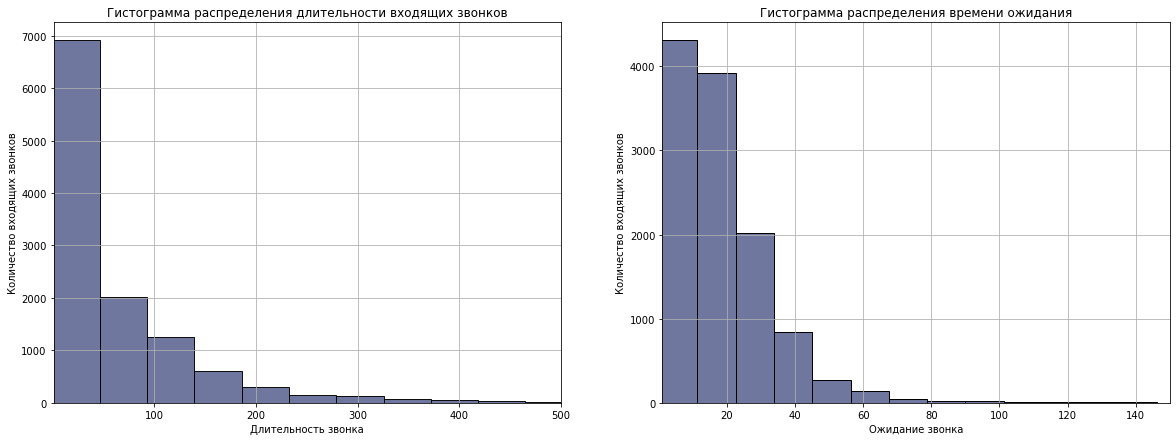

In [56]:
plt.figure(figsize=(20, 7))
ax1 = plt.subplot(1, 2, 1)
sns.histplot(data=good_data_in, x="one_call_duration", bins=50, color='#3F497F', ax=ax1)
plt.title("Гистограмма распределения длительности входящих звонков")
plt.ylabel("Количество входящих звонков")
plt.xlabel("Длительность звонка")
plt.grid()
ax1.set_xlim(1, 500)

ax2 = plt.subplot(1, 2, 2)
sns.histplot(data=good_data_in, x="waiting_time", bins=20, color='#3F497F', ax=ax2)
plt.title("Гистограмма распределения времени ожидания")
plt.ylabel("Количество входящих звонков")
plt.xlabel("Ожидание звонка")
plt.grid()
ax2.set_xlim(1, 150);

In [57]:
good_data_in.describe().T

,count,mean,std,min,25%,50%,75%,max
operator_id,11596.0,671794.032425,408566.155441,0.0,0.000000,908958.0000,921818.00,973286.0
calls_count,11596.0,7.976716,16.436719,1.0,1.000000,2.0000,7.00,341.0
call_duration,11596.0,468.856847,1368.461485,0.0,0.000000,30.0000,357.25,33897.0
total_call_duration,11596.0,607.288375,1499.834339,0.0,32.000000,124.0000,532.25,34280.0
one_call_duration,11596.0,59.467944,100.727773,0.0,0.000000,22.0000,87.00,2325.0
one_total_call_duration,11596.0,77.358644,101.554267,0.0,18.333333,45.5000,104.60,2329.0
waiting_time,11596.0,17.890699,14.696622,0.0,8.000000,14.8875,24.50,225.0


Большинство входящих звонков до 100 секунд. Большинство звонков ожидали до 25 секунд. Среднее время ожидания: 18 секунд

Проверим среднее время ожидания среди пропущенных и не пропущенных звонков.

In [58]:
good_data_in.query('is_missed_call==False')['waiting_time'].mean()

16.99963915019043

In [59]:
good_data_in.query('is_missed_call==True')['waiting_time'].mean()

19.11353742529625

Среднее время ожидания среди пропущенных звонков: 19 секунд. Следовательно,  в среднем люди не готовы ждать больше 19 секунд. 

Примем за критерий эффективности среднее значение ожидания среди пропущенных звонков: 19 секунд. Если  время ожидания у оператора больше этого значения, то оператор признается неэффективным по этому критерию. 

Рассчитаем среднее значение времени ожидания  по каждому оператору

Проверим, точно ли нет `operator_id`, которые встречаются сразу в нескольких колл-центрах.

In [60]:
operator_per_user = good_data_in.pivot_table(index='operator_id', values='user_id',aggfunc='nunique')
operator_per_user.sort_values(by='user_id', ascending=False)

,user_id
operator_id,
0,166
935548,1
938432,1
938414,1
936984,1
...,...
909896,1
909894,1
909892,1


Так как кроме пропущенных значений, которые мы заменили на 0, больше повторяющихся операторов нет, 
то скорее всего `operator_id` с 0 - это тоже  разные операторы. Поэтому сгруппируем строки по колл-центру и оператору, 
рассчитаем среднее время для каждого оператора и сравним с  порогом эффективности.

In [61]:
#сводная таблица для определения среднего времени ожидания на оператора
time_operator = good_data_in.pivot_table(index=['user_id','operator_id'], \
                                         values='waiting_time', aggfunc='mean')
time_operator = time_operator.reset_index()

In [62]:
def eff_operator(waiting_time):
    """ Функция определяет эффективность в зависимости от времени ожидания
    """
    if waiting_time<19:
        return 'effective'
    return 'ineffective'

In [63]:
#применение функции к столбцу
time_operator['grade_time']=  time_operator['waiting_time'].apply(eff_operator)

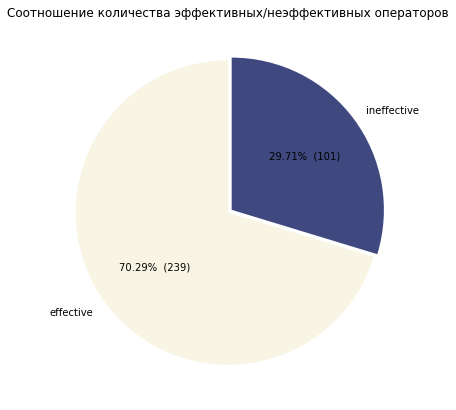

In [64]:
# соотношение эффективных/неэффективных операторов
plt.figure(figsize=(7, 7))
explode = (0, 0.03)
valu1 = time_operator.groupby('grade_time')['operator_id'].nunique().tolist()
def make_autopct(valu1):
    """ Эта функция позволяет показать на круговой диаграмме относительные и абсолютные значения
    
    Она принимает на вход список из абсолютных значений, по которым строится диаграмма
    """
    def my_autopct(pct):
        total = sum(valu1)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
time_operator.groupby('grade_time')['operator_id'].nunique().\
plot(kind='pie',autopct=make_autopct(valu1),ylabel='',colors=['#F8F5E4','#3F497F'], explode=explode,\
     startangle=90, title='Cоотношение количества эффективных/неэффективных операторов');

30% операторов неэффективны согласно данному критерию.

In [65]:
time_operator = time_operator[['user_id','operator_id','grade_time']]# оставили только релевантные столбцы

Добавим столбец с оценкой эффективности в изначальную таблицу

In [66]:
good_data_in = good_data_in.merge(time_operator, on = ['user_id','operator_id'])

Проверим долю пропущенных звонков среди эффективных и не эффективных операторов. То есть среди тех, время ожидания, у которых <19 секунд и больше соответственно.

In [128]:
cor = good_data_in.pivot_table(index='grade_time', columns='is_missed_call', values='calls_count', aggfunc='sum', \
                               margins=True, margins_name='total').reset_index()
cor.columns=['grade_time','not_missed','missed','total']

In [68]:
cor['missed_rate'] = round(100*cor['missed']/cor['total'],2)
cor

,grade_time,not_missed,missed,total,missed_rate
0,effective,44413,21928,66341,33.05
1,ineffective,12791,13366,26157,51.10
2,total,57204,35294,92498,38.16


Среди неэффективных операторов 51% звонков пропущенные.  

#### Оценка эффективности по количеству пропущенных звонков

In [69]:
# сводная по количеству пропущенных/непропущенных звонков
missed_calls=good_data_in.pivot_table(index='operator_id',columns='is_missed_call',
               values='calls_count',aggfunc='sum', fill_value=0, margins=True,margins_name="total")
missed_calls = missed_calls.reset_index()

In [70]:
missed_calls.columns = ['operator_id','not_missed','missed','total']# переименование столбцов

In [71]:
# расчет доли пропущенных звонков
missed_calls['missed_rate']=round(100*missed_calls['missed']/missed_calls['total'],2)
missed_calls['not_missed_rate'] = 100-missed_calls['missed_rate']
missed_calls.sample(10)

,operator_id,not_missed,missed,total,missed_rate,not_missed_rate
313,956664,1,0,1,0.00,100.00
302,955068,0,2,2,100.00,0.00
134,914168,9,2,11,18.18,81.82
221,934534,125,2,127,1.57,98.43
233,939370,829,142,971,14.62,85.38
183,928022,4,0,4,0.00,100.00
18,891918,5,1,6,16.67,83.33
60,899892,3,0,3,0.00,100.00
309,956276,11,6,17,35.29,64.71
97,907974,3,0,3,0.00,100.00


In [72]:
missed_calls.describe().T

,count,mean,std,min,25%,50%,75%,max
not_missed,340.0,336.494118,3139.910330,0.0,4.000,15.00,87.000,57204.0
missed,340.0,207.611765,2382.394759,0.0,0.000,1.00,9.000,35294.0
total,340.0,544.105882,5235.130943,1.0,5.000,19.00,99.000,92498.0
missed_rate,340.0,13.468029,19.962066,0.0,0.000,4.54,20.365,100.0
not_missed_rate,340.0,86.531971,19.962066,0.0,79.635,95.46,100.000,100.0


Примем за критерий эффективности  значение доли пропущенных звонков: 14%. Если  доля пропущенных звонков у оператора 
больше этого значения, то оператор признается неэффективным по этому критерию. Так как среднее значение - это числовая характеристика множества чисел. Если в среднем операторы пропускают не больше 14% звонков, значит это типичный показатель, которого в среднем могут достигнуть все операторы.

In [73]:
def eff_operator_missed(missed_rate):
    """ Функция определяет эффективность в зависимости от доли пропущенных звонков
    """
    if missed_rate<14:
        return 'effective'
    return 'ineffective'

In [74]:
# применение функции к столбцу
missed_calls['grade_missed']=  missed_calls['missed_rate'].apply(eff_operator_missed)

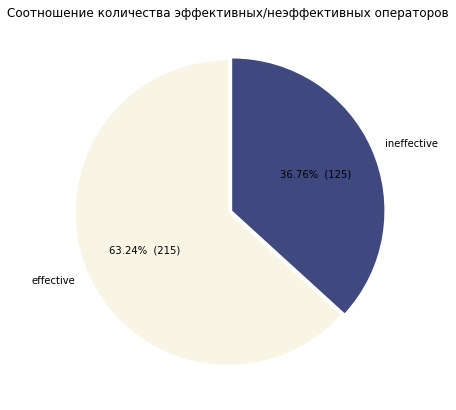

In [75]:
# соотношение эффективных/неэффективных операторов
plt.figure(figsize=(7, 7))
explode = (0, 0.03)
valu1 = missed_calls.groupby('grade_missed')['operator_id'].nunique().tolist()
def make_autopct(valu1):
    """ Эта функция позволяет показать на круговой диаграмме относительные и абсолютные значения
    
    Она принимает на вход список из абсолютных значений, по которым строится диаграмма
    """
    def my_autopct(pct):
        total = sum(valu1)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
missed_calls.groupby('grade_missed')['operator_id'].nunique().\
plot(kind='pie',autopct=make_autopct(valu1),ylabel='',colors=['#F8F5E4','#3F497F'], explode=explode,\
     startangle=90, title='Cоотношение количества эффективных/неэффективных операторов');

37% операторов неэффективны согласно данному критерию.

In [76]:
missed_calls = missed_calls[['operator_id','grade_missed']]# оставили только релевантные столбцы

Добавим столбец с оценкой эффективности в изначальную таблицу

In [77]:
good_data_in = good_data_in.merge(missed_calls, on = ['operator_id'])

Для итоговой оценки эффективности, заменим значения в столбцах с оценками: `effective` : 1, `ineffective` : 0

In [78]:
good_data_in = good_data_in.replace({'grade_missed' : {'effective' : 1, 'ineffective' : 0}})

In [79]:
good_data_in = good_data_in.replace({'grade_time' : {'effective' : 1, 'ineffective' : 0}})

In [80]:
# вычисление итоговой эффективности
good_data_in['grade'] = good_data_in['grade_missed']+good_data_in['grade_time']

Эффективными будем считать только тех операторов, у кого и среднее время ожидания и доля пропущенных звонков меньше порогов.

In [81]:
def define_grade(grade): # функция для определения итоговой оценки
    if grade==2:
        return 'effective'
    else:
        return 'ineffective'

In [82]:
good_data_in['grade']=good_data_in['grade'].apply(define_grade)# создание нового столбца с итоговой оценкой

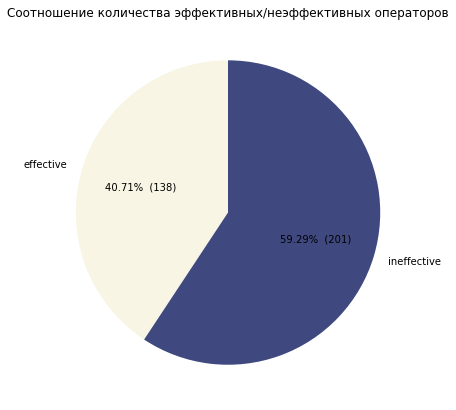

In [83]:
# соотношение эффективных/неэффективных операторов
plt.figure(figsize=(7, 7))
valu1 = good_data_in.groupby('grade')['operator_id'].nunique().tolist()
def make_autopct(valu1):
    """ Эта функция позволяет показать на круговой диаграмме относительные и абсолютные значения
    
    Она принимает на вход список из абсолютных значений, по которым строится диаграмма
    """
    def my_autopct(pct):
        total = sum(valu1)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
good_data_in.groupby('grade')['operator_id'].nunique().\
plot(kind='pie',autopct=make_autopct(valu1),ylabel='',colors=['#F8F5E4','#3F497F'],\
     startangle=90, title='Cоотношение количества эффективных/неэффективных операторов');

**Вывод:**

Всего 169 колл-центров, специализирующихся на входящих звонках. В них работает 339 операторов (339 рабочих аккаунтов). В основном по 2 оператора на колл-центр. В среднем один входящий звонок длится 60 секунд.

Среднее время ожидания звонка среди пропущенных звонков: 19 секунд. 30% операторов неэффективны согласно среднему времени ожидания. 

14% - средняя доля пропущенных звонков. 37% неэффективны по доле пропущенных звонков. 
 
Учитывая сразу 2 критерия, 60% операторов неэффективны


### Анализ данных по исходящим звонкам

In [84]:
# срез  колл-центров, специализирующихся на исходящих звонках
good_data_out = good_data.query('group=="out_group"')

In [85]:
#количество колл-центров, специализирующихся на исходящих звонках 
good_data_out['user_id'].nunique()

137

In [86]:
#суммарное количество операторов, работающих в колл-центрах, специализирующихся на исходящих звонках
good_data_out['operator_id'].nunique()

755

In [87]:
#количество операторов, для каждого колл-центра
quantity_per_user = good_data_out.pivot_table(index='user_id', values='operator_id', aggfunc='nunique')

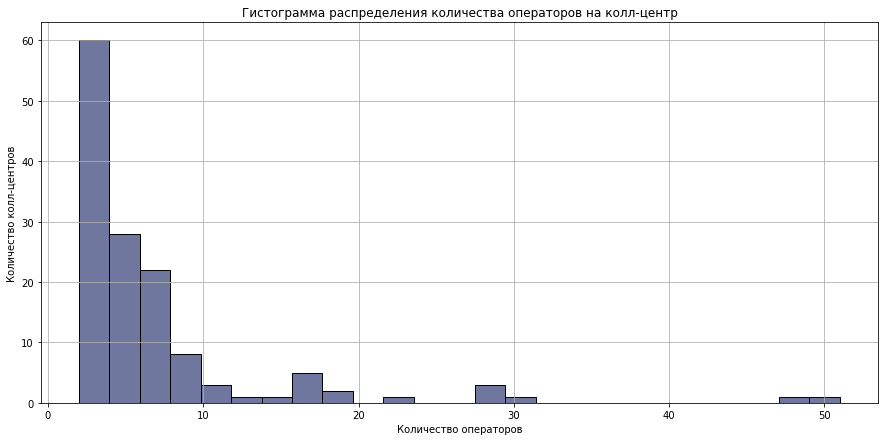

In [88]:
plt.figure(figsize=(15, 7))
sns.histplot(data=quantity_per_user, x="operator_id", bins=25, color='#3F497F')
plt.title("Гистограмма распределения количества операторов на колл-центр")
plt.ylabel("Количество колл-центров")
plt.xlabel("Количество операторов")
plt.grid()

In [89]:
good_data_out.groupby('user_id')['operator_id'].nunique().describe()

count    137.000000
mean       6.503650
std        7.758415
min        2.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       51.000000
Name: operator_id, dtype: float64

В 75% колл-центров работает по 7 операторов.

In [90]:
good_data_out.describe().T

,count,mean,std,min,25%,50%,75%,max
operator_id,36433.0,821734.546428,278522.417957,0.0,891162.000000,906406.000000,932460.000000,973120.0
calls_count,36433.0,18.266956,56.213053,1.0,2.000000,5.000000,15.000000,1432.0
call_duration,36433.0,927.198556,3246.124985,0.0,0.000000,45.000000,682.000000,74815.0
total_call_duration,36433.0,1255.691488,3890.644286,0.0,57.000000,257.000000,1073.000000,82634.0
one_call_duration,36433.0,68.644688,130.826959,0.0,0.000000,25.500000,91.250000,3550.0
one_total_call_duration,36433.0,85.191875,130.107406,0.0,20.461538,45.000000,106.000000,3609.0
waiting_time,36433.0,16.547186,13.515966,0.0,8.000000,14.529412,21.764706,465.0


В среднем по 18 исходящих звонков на оператора. Примем это значение за порог эффективности

Проверим наличие операторов, работающих в нескольких колл-центрах.

In [91]:
operator_per_user = good_data_out.pivot_table(index='operator_id', values='user_id',aggfunc='nunique')
operator_per_user.sort_values(by='user_id', ascending=False)

,user_id
operator_id,
0,137
938080,1
937966,1
937980,1
937984,1
...,...
914816,1
914842,1
914848,1


Так как кроме пропущенных значений, которые мы заменили на 0, больше повторяющихся операторов нет, 
то скорее всего `operator_id` с 0 - это тоже все разные операторы. Поэтому сгруппируем строки по колл-центру и оператору, 
рассчитаем среднее количество звонков для каждого оператора и сравним с  порогом эффективности.

In [92]:
qn_operator = good_data_out.pivot_table(index=['user_id','operator_id'], \
                                         values='calls_count', aggfunc='mean')
qn_operator = qn_operator.reset_index()

In [93]:
def eff_operator(calls_count):
    """ Функция определяет эффективность в зависимости от времени ожидания
    """
    if calls_count<18:
        return 'effective'
    return 'ineffective'

In [94]:
qn_operator ['grade']=  qn_operator ['calls_count'].apply(eff_operator)# применение функции к столбцу

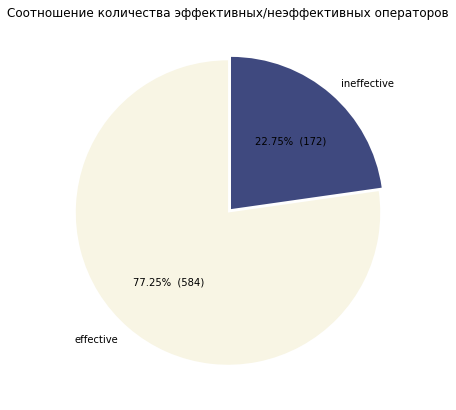

In [95]:
# соотношение эффективных/неэффективных операторов
plt.figure(figsize=(7, 7))
explode = (0, 0.03)
valu1 = qn_operator .groupby('grade')['operator_id'].nunique().tolist()
def make_autopct(valu1):
    """ Эта функция позволяет показать на круговой диаграмме относительные и абсолютные значения
    
    Она принимает на вход список из абсолютных значений, по которым строится диаграмма
    """
    def my_autopct(pct):
        total = sum(valu1)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
qn_operator.groupby('grade')['operator_id'].nunique().\
plot(kind='pie',autopct=make_autopct(valu1),ylabel='',colors=['#F8F5E4','#3F497F'], explode=explode,\
     startangle=90, title='Cоотношение количества эффективных/неэффективных операторов');

24% операторов неэффективны

In [96]:
qn_operator = qn_operator[['user_id','operator_id','grade']]# оставили только релевантные столбцы

In [97]:
# добавление столбца с оценкой в первоначальную таблицу
good_data_out = good_data_out.merge(qn_operator, on = ['user_id','operator_id'])

**Вывод:**

Всего 137 колл-центров, специализирующихся на исходящих звонках. В них работает 755 операторов. В большинстве колл-центров не больше 10 операторов.

В среднем по 18 звонков на оператора. 24% операторов неэффективны согласно данному критерию.


### Анализ целесообразности разработки сервиса

Объединим таблицы с данными по входящим и исходящим звонкам, оценим общую долю неэффективных операторов. И определим количество колл-центров, в которых есть такие операторы

In [98]:
good_data = pd.concat([good_data_in, good_data_out],sort=False,axis=0)#объединение таблиц

In [99]:
good_data.info()# проверка количества строк после объединения

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48029 entries, 0 to 36432
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype                                
---  ------                   --------------  -----                                
 0   user_id                  48029 non-null  object                               
 1   date                     48029 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction                48029 non-null  object                               
 3   internal                 48029 non-null  object                               
 4   operator_id              48029 non-null  object                               
 5   is_missed_call           48029 non-null  bool                                 
 6   calls_count              48029 non-null  int64                                
 7   call_duration            48029 non-null  int64                                
 8   total_call_duration      48029 non-null  int64

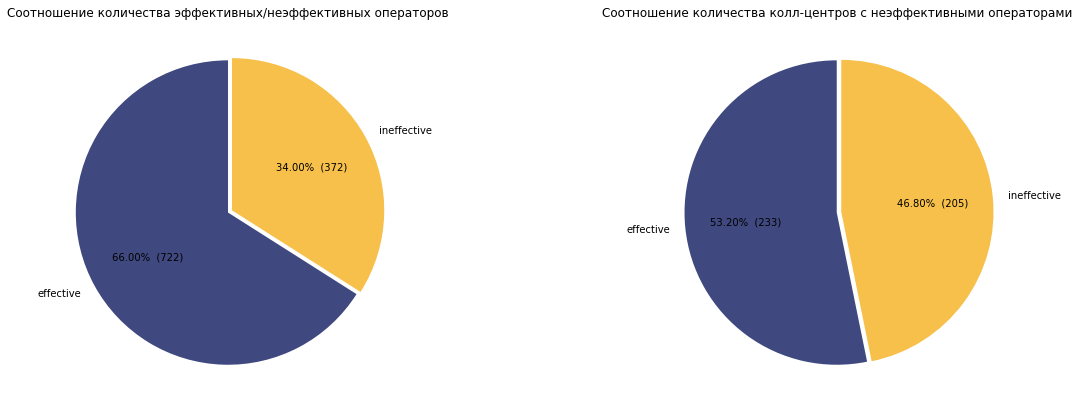

In [100]:
# соотношение эффективных/неэффективных операторов
plt.figure(figsize=(20, 7))
ax1 = plt.subplot(1, 2, 1)
explode = (0, 0.03)
valu1 = good_data.groupby('grade')['operator_id'].nunique().tolist()
def make_autopct(valu1):
    """ Эта функция позволяет показать на круговой диаграмме относительные и абсолютные значения
    
    Она принимает на вход список из абсолютных значений, по которым строится диаграмма
    """
    def my_autopct(pct):
        total = sum(valu1)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
good_data.groupby('grade')['operator_id'].nunique().\
plot(kind='pie',autopct=make_autopct(valu1),ylabel='',colors=['#3F497F','#F7C04A'], explode=explode,\
     startangle=90, title='Cоотношение количества эффективных/неэффективных операторов', ax=ax1);

# соотношение количества колл-центров с неэффективными операторами
ax2 = plt.subplot(1, 2, 2)
explode = (0, 0.03)
valu1 = good_data.groupby('grade')['user_id'].nunique().tolist()
def make_autopct(valu1):
    """ Эта функция позволяет показать на круговой диаграмме относительные и абсолютные значения
    
    Она принимает на вход список из абсолютных значений, по которым строится диаграмма
    """
    def my_autopct(pct):
        total = sum(valu1)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
good_data.groupby('grade')['user_id'].nunique().\
plot(kind='pie',autopct=make_autopct(valu1),ylabel='',colors=['#3F497F','#F7C04A'], explode=explode,\
     startangle=90, title='Cоотношение количества колл-центров с неэффективными операторами', ax=ax2);

В итоговом датафрейме 34% операторов неэффективны. Данные операторы работают в  47% колл-центрах. 
Проверим какова доля неэффективных операторов в этих 47% процентах.

In [101]:
good_data.query('grade=="ineffective"')['user_id'].nunique()# всего колл-центров с неэффективными операторами

205

In [102]:
# сводная по количеству операторов
qn = good_data.pivot_table(index='user_id',columns='grade',values = 'operator_id', aggfunc='count',margins=True, margins_name='total')

In [103]:
qn = qn.dropna(subset=['ineffective'])# удаление пропусков

In [104]:
qn['ineffective_rate'] = round(100*qn['ineffective']/qn['total'],2)# расчет доли неэффективных операторов

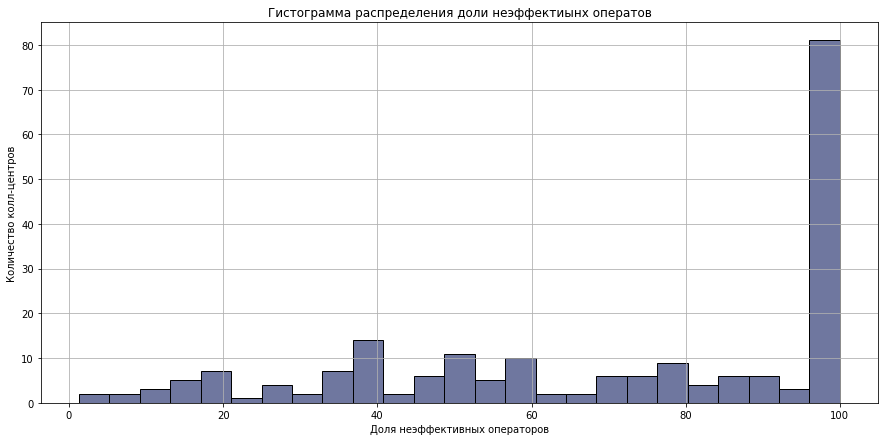

In [105]:
plt.figure(figsize=(15, 7))
sns.histplot(data=qn, x="ineffective_rate", bins=25, color='#3F497F')
plt.title("Гистограмма распределения доли неэффектиынх оператов")
plt.ylabel("Количество колл-центров")
plt.xlabel("Доля неэффективных операторов")
plt.grid()

In [106]:
qn['ineffective_rate'].describe()# статистика

count    206.000000
mean      70.923981
std       30.172796
min        1.300000
25%       45.910000
50%       78.475000
75%      100.000000
max      100.000000
Name: ineffective_rate, dtype: float64

In [107]:
# расчет колл-центров где доля неэффективных операторов >=30
round(100*qn.query('ineffective_rate>=30')['ineffective_rate'].count()/qn['ineffective_rate'].count(),2)

88.35

Из 48% колл-центров, где есть неэффективные операторы, у 75% все операторы неэффективны. У 88% колл-центров доля неэффективных операторов >= 30%.  

In [108]:
total = good_data.query('grade=="effective"')['user_id'].nunique()+good_data.query('grade=="ineffective"')['user_id'].nunique()

In [109]:
# расчет итогового процента
percentage = round(good_data.query('grade=="ineffective"')['user_id'].nunique()/total,2)
rate = round(qn.query('ineffective_rate>=30')['ineffective_rate'].count()/qn['ineffective_rate'].count(),2)
final_percentage = percentage*rate*100
final_percentage

41.36

**Вывод:**

Новая услуга сервиса "Нупозвони" может представлять интерес для 42%  колл-центров. 

### Анализ колл-центров по тарифам

Проанализируем количество клиентов и операторов по тарифам

In [110]:
data = good_data.merge(clients, on='user_id', how='outer')# объединение таблицы с данными с тарифными планами

In [111]:
# сводная по тарифам: количество клиентов
user_per_tariff = data.pivot_table(index='tariff_plan', values='user_id',\
                                     aggfunc='nunique').reset_index()
user_per_tariff = user_per_tariff.sort_values(by='user_id', ascending=False)

In [112]:
# сводная по тарифам: количество операторов
operator_per_tariff = data.pivot_table(index='tariff_plan', values='operator_id',\
                                     aggfunc='nunique').reset_index()
operator_per_tariff = operator_per_tariff.sort_values(by='operator_id', ascending=False)

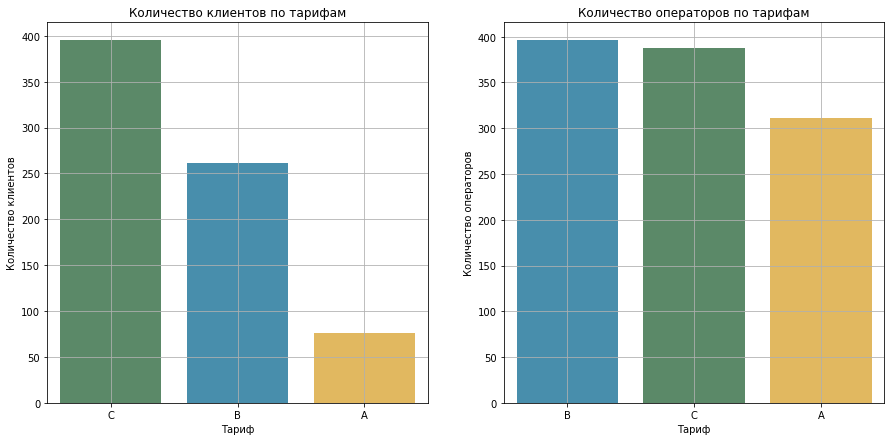

In [113]:
plt.figure(figsize=(15, 7))
colors=['#539165','#3795BD','#F7C04A']
ax1 = plt.subplot(1, 2, 1)
sns.barplot(data=user_per_tariff, x='tariff_plan',y='user_id',palette=colors, ax=ax1)
plt.title("Количество клиентов по тарифам")
plt.ylabel("Количество клиентов")
plt.xlabel("Тариф")
plt.grid()

ax2 = plt.subplot(1, 2, 2)
colors=['#3795BD','#539165','#F7C04A']
sns.barplot(data=operator_per_tariff, x='tariff_plan',y='operator_id',palette=colors, ax=ax2)
plt.title("Количество операторов по тарифам")
plt.ylabel("Количество операторов")
plt.xlabel("Тариф")
plt.grid()

Большинство клиентов используют тариф С. При этом большинство операторов работают в колл-центрах с тарифом В. 

В дальнейшем проанализируем одинаково ли среднее значение неэффективных операторов для тарифов.

**Вывод:**

Данные представлены в диапазоне между 28 ноября 2019г. и 8 февраля 2019г. К выходным дням нагрузка на операторов снижается.

55% колл-центров относится к категории входящие. Всего таких колл-центров: 169 . В них работает 339 операторов (339 рабочих аккаунтов). В основном по 2 оператора на колл-центр. В среднем один входящий звонок длится 60 секунд.
Для оценки эффективности заданы два критерия: 
- среднее время ожидания звонка: 19 секунд
- средняя доля пропущенных звонков: 14%

Учитывая сразу 2 критерия, 60% операторов неэффективны.

Колл-центров, специализирующихся на исходящих звонках: 137. В них работает 755 операторов. В большинстве колл-центров не больше 10 операторов.В среднем по 18 исходящих звонка на оператора. 24% операторов неэффективны согласно данному критерию.

В объединенном датафрейме 34% операторов неэффективны. Данные операторы работают в  47% колл-центрах. 
Из этих 47% колл-центров, в 75% все операторы неэффективны. Итого для 42% наших клиентов сервис будет интересен.

При этом большинство клиентов используют тариф С. Проверим одинаково ли среднее значение неэффективных операторов для тарифов.

## Проверка статистических гипотез

### Проверка гипотез для входящих звонков

**Нулевая гипотеза:** Среднее значение количества неэффективных операторов для входящих звонков тарифов «A» и «B» одинаково. 

**Альтернативная гипотеза:** Среднее значение количества неэффективных операторов для входящих звонков тарифов «A» и «B» различается.

In [114]:
#расчет количества неэффективных операторов по дням для  разных тарифов
eff_per_tariff=data.query('direction=="in"').\
pivot_table(index= ['tariff_plan', 'date'], values = 'grade',aggfunc='count').reset_index()
eff_per_tariff.head()

,tariff_plan,date,grade
0,A,2019-08-08 00:00:00+03:00,1
1,A,2019-08-09 00:00:00+03:00,2
2,A,2019-08-12 00:00:00+03:00,4
3,A,2019-08-13 00:00:00+03:00,4
4,A,2019-08-14 00:00:00+03:00,4


Проверим количество значений, которое мы будем передавать в метод для проверки гипотезы

In [115]:
eff_per_tariff.query('tariff_plan == "A"')['grade'].shape[0]

111

In [116]:
eff_per_tariff.query('tariff_plan == "B"')['grade'].shape[0]

119

In [117]:
eff_per_tariff.query('tariff_plan == "C"')['grade'].shape[0]

115

Так как мы проверяем  гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, то воспользуемся t-тест

In [118]:
print('Нулевая гипотеза: Среднее значение количества неэффективных операторов для входящих звонков тарифов «A» и «B» одинаково')

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу. Гипотеза двухсторонняя

results = st.ttest_ind(eff_per_tariff.query('tariff_plan == "A"')['grade'], \
                       eff_per_tariff.query('tariff_plan == "B"')['grade'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Нулевая гипотеза: Среднее значение количества неэффективных операторов для входящих звонков тарифов «A» и «B» одинаково
p-значение: 0.0012067215011664191
Отвергаем нулевую гипотезу


**Нулевая гипотеза:** Среднее значение количества неэффективных операторов для входящих звонков тарифов «A» и «С» одинаково. 

**Альтернативная гипотеза:** Среднее значение количества неэффективных операторов для входящих звонков тарифов «A» и «С» различается.

In [119]:
print('Нулевая гипотеза: Среднее значение количества неэффективных операторов для входящих звонков тарифов «A» и «С» одинаково')

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу. Гипотеза двухсторонняя

results = st.ttest_ind(eff_per_tariff.query('tariff_plan == "A"')['grade'], \
                       eff_per_tariff.query('tariff_plan == "C"')['grade'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Нулевая гипотеза: Среднее значение количества неэффективных операторов для входящих звонков тарифов «A» и «С» одинаково
p-значение: 1.8150568761837843e-07
Отвергаем нулевую гипотезу


**Нулевая гипотеза:** Среднее значение количества неэффективных операторов для входящих звонков тарифов «B» и «С» одинаково. 

**Альтернативная гипотеза:** Среднее значение количества неэффективных операторов для входящих звонков тарифов «B» и «С» различается.

In [120]:
print('Нулевая гипотеза: Среднее значение количества неэффективных операторов для входящих звонков тарифов «B» и «С» одинаково')

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу. Гипотеза двухсторонняя

results = st.ttest_ind(eff_per_tariff.query('tariff_plan == "B"')['grade'], \
                       eff_per_tariff.query('tariff_plan == "C"')['grade'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Нулевая гипотеза: Среднее значение количества неэффективных операторов для входящих звонков тарифов «B» и «С» одинаково
p-значение: 0.014273550757371125
Отвергаем нулевую гипотезу


**Вывод**

Нет оснований полагать, что среднее значение количества неэффективных операторов для входящих звонков по тарифам одинаково

### Проверка гипотез для исходящих звонков

**Нулевая гипотеза:** Среднее значение количества неэффективных операторов для исходящих звонков тарифов «A» и «B» одинаково. 

**Альтернативная гипотеза:** Среднее значение количества неэффективных операторов для исходящих звонков тарифов «A» и «B» различа

In [121]:
#расчет количества неэффективных операторов по дням для  разных тарифов
eff_per_tariff_out=data.query('direction=="out"').\
pivot_table(index= ['tariff_plan', 'date'], values = 'grade',aggfunc='count').reset_index()
eff_per_tariff_out.head()

,tariff_plan,date,grade
0,A,2019-08-12 00:00:00+03:00,4
1,A,2019-08-13 00:00:00+03:00,6
2,A,2019-08-14 00:00:00+03:00,9
3,A,2019-08-15 00:00:00+03:00,6
4,A,2019-08-16 00:00:00+03:00,5


Проверим количество значений, которое мы будем передавать в метод для проверки гипотезы

In [122]:
eff_per_tariff_out.query('tariff_plan == "A"')['grade'].shape[0]

109

In [123]:
eff_per_tariff_out.query('tariff_plan == "B"')['grade'].shape[0]

118

In [124]:
eff_per_tariff_out.query('tariff_plan == "C"')['grade'].shape[0]

108

In [125]:
print('Нулевая гипотеза: Среднее значение количества неэффективных операторов для исходящих звонков тарифов «A» и «B» одинаково')

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу. Гипотеза двухсторонняя

results = st.ttest_ind(eff_per_tariff_out.query('tariff_plan == "A"')['grade'], \
                       eff_per_tariff_out.query('tariff_plan == "B"')['grade'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Нулевая гипотеза: Среднее значение количества неэффективных операторов для исходящих звонков тарифов «A» и «B» одинаково
p-значение: 0.4718426951367004
Не получилось отвергнуть нулевую гипотезу


**Нулевая гипотеза:** Среднее значение количества неэффективных операторов для исходящих звонков тарифов «A» и «С» одинаково. 

**Альтернативная гипотеза:** Среднее значение количества неэффективных операторов для исходящих звонков тарифов «A» и «С» разл

In [126]:
print('Нулевая гипотеза: Среднее значение количества неэффективных операторов для исходящих звонков тарифов «A» и «С» одинаково')

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу. Гипотеза двухсторонняя

results = st.ttest_ind(eff_per_tariff_out.query('tariff_plan == "A"')['grade'], \
                       eff_per_tariff_out.query('tariff_plan == "C"')['grade'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Нулевая гипотеза: Среднее значение количества неэффективных операторов для исходящих звонков тарифов «A» и «С» одинаково
p-значение: 0.3055217672618398
Не получилось отвергнуть нулевую гипотезу


**Нулевая гипотеза:** Среднее значение количества неэффективных операторов для исходящих звонков тарифов «B» и «С» одинаково. 

**Альтернативная гипотеза:** Среднее значение количества неэффективных операторов для исходящих звонков тарифов «B» и «С» различается

In [127]:
print('Нулевая гипотеза: Среднее значение количества неэффективных операторов для исходящих звонков тарифов «B» и «С» одинаково')

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу. Гипотеза двухсторонняя

results = st.ttest_ind(eff_per_tariff_out.query('tariff_plan == "B"')['grade'], \
                       eff_per_tariff_out.query('tariff_plan == "C"')['grade'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Нулевая гипотеза: Среднее значение количества неэффективных операторов для исходящих звонков тарифов «B» и «С» одинаково
p-значение: 0.7383500322624412
Не получилось отвергнуть нулевую гипотезу


**Вывод**

Нет оснований полагать, что среднее значение количества неэффективных операторов для исходящих звонков 
по тарифам различается.

## Вывод

В ходе исследования эффективности операторов колл-центров в основном датасете были удалены дубликаты, пропуски. Пропуски в колонке с `operator_id` для входящих, пропущенных и внешних были заменены на 0. Столбцы с датами были приведены к соответствующему типу. Также были удалены выбросы. Общая доля удаленных строк не превысила 11%.
Данные представлены в диапазоне между 28 ноября 2019г. и 8 февраля 2019г. К выходным дням нагрузка на операторов снижается.

55% колл-центров относится к категории входящие. Всего таких колл-центров: 169. В них работает 339 операторов (339 рабочих аккаунтов). В основном по 2 оператора на колл-центр. В среднем один входящий звонок длится 60 секунд.
Для оценки эффективности заданы два критерия: 
- среднее время ожидания звонка среди пропущенных звонков: 19 секунд
- средняя доля пропущенных звонков: 14%

Учитывая сразу 2 критерия, 60% операторов неэффективны.

Колл-центров, специализирующихся на исходящих звонках: 137. В них работает 755 операторов. В большинстве колл-центров не больше 10 операторов.В среднем по 18 исходящих звонка на оператора. 24% операторов неэффективны согласно данному критерию.

Для 42% наших клиентов сервис будет интересен. При этом большинство клиентов используют тариф С. 
Нет оснований полагать, что среднее значение количества неэффективных операторов для входящих звонков по тарифам одинаково.
Для исходящих звонков нет статистического значимого различия по тарифам в среднем значении количества неэффективных операторов.

Следовательно, разработка алгоритма оценки эффективности операторов целесообразна. Так как большой процент наших клиентов имеет неэффективных операторов. Также для клиентов, специализирующихся на входящих звонках (их большинство), есть зависимость между тарифом и количеством неэффективных операторов. Это может служить возможностью для предложения более дорогих тарифов.